<a href="https://colab.research.google.com/github/Anantha-Rao12/Decoding-Quantum-States-with-NMR/blob/main/05_Newdataset_power_vs_nonpower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")

from NMR_ML import Dataset, Polynomial_features, FeatureImportancePlot, FourierTransform

# from auxillary_functions import *
# from polyfeat_imp import *
# from polynomial_featextract import poly_featextract

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Gaussian Data

In [2]:
# import raw data and params.txt file
gauss = Dataset("/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-08-14_gauss")

rawdata_gaus = gauss.load_data()
params_gaus = gauss.load_params()
ker_integrals_gaus = gauss.load_wlist() # load wlist.txt file
y_classes_gaus = gauss.get_yclasses()

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

print("Raw data shape:",rawdata_gaus.shape)

# Rescaled data
rscl_df_gaus, _ = gauss.get_window(rawdata_gaus, center_ratio=2/3, width=150)

Finished loading rawdata into numpy array
Finished loading parameters file
Finished loading kernel-integrals file.
Finished loading parameters file
Finished loading kernel-integrals file.
Raw data shape: (5000, 1885)
The Echo pulse occurs at timestep: 1256


# Power law data

In [3]:
# import raw data and params.txt file
power = Dataset("/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-08-14_power")

rawdata_power = power.load_data()
params_power = power.load_params()
ker_integrals_power = power.load_wlist() # load wlist.txt file
y_classes_power = power.get_yclasses()

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

print("Raw data shape:",rawdata_power.shape)

# Rescaled data
rscl_df_power, _ = power.get_window(rawdata_power, center_ratio=2/3, width=150)

Finished loading rawdata into numpy array
Finished loading parameters file
Finished loading kernel-integrals file.
Finished loading parameters file
Finished loading kernel-integrals file.
Raw data shape: (5000, 1885)
The Echo pulse occurs at timestep: 1256


# RKKY data

In [4]:
# import raw data and params.txt file

rkky = Dataset("/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-08-14_RKKY")

rawdata_rkky = rkky.load_data()
params_rkky = rkky.load_params()
ker_integrals_rkky = rkky.load_wlist() # load wlist.txt file
y_classes_rkky = rkky.get_yclasses()

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

print("Raw data shape:",rawdata_rkky.shape)

# Rescaled data
rscl_df_rkky, _ = rkky.get_window(rawdata_rkky, center_ratio=2/3, width=150)

Finished loading rawdata into numpy array
Finished loading parameters file
Finished loading kernel-integrals file.
Finished loading parameters file
Finished loading kernel-integrals file.
Raw data shape: (5000, 1885)
The Echo pulse occurs at timestep: 1256


# Classification

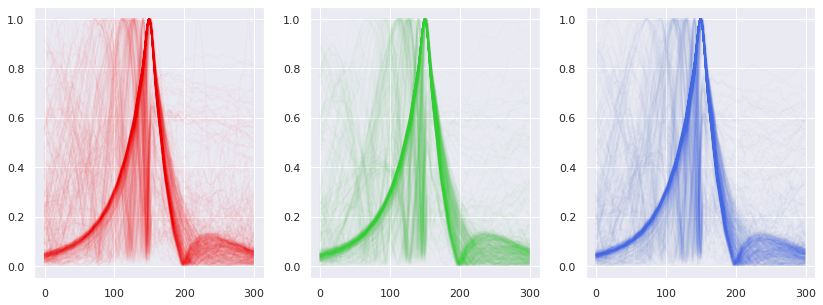

In [7]:
fig, axes = plt.subplots(1,3,figsize=(14,5))

axes[0].plot(rscl_df_gaus.to_numpy()[::10].T, color='red', alpha=0.02)
axes[1].plot(rscl_df_power.to_numpy()[::10].T, color='limegreen', alpha=0.02)
axes[2].plot(rscl_df_rkky.to_numpy()[::10].T, color='royalblue', alpha=0.02)
plt.show()

In [14]:
x = np.vstack((rscl_df_gaus.to_numpy(),rscl_df_power.to_numpy(),rscl_df_rkky.to_numpy()))
y = np.array([0]*len(rscl_df_gaus)+[1]*len(rscl_df_power)+[0]*len(rscl_df_rkky))
x_kerintegrals_df = pd.DataFrame(np.vstack((ker_integrals_gaus,ker_integrals_power,ker_integrals_rkky)))

x_df = pd.DataFrame(x ,columns=[f"feat_{i}" for i in range(len(x[0]))])
y_df = pd.DataFrame(y.reshape(15000,1), columns=['label'])

## Training a Random Forest model

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, stratify=y_df.label, random_state=101 )

### Oversampling on (x_df, y_df)

In [42]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
ovs = RandomOverSampler(random_state=101)
#ovs = SMOTETomek()
x_res, y_res = ovs.fit_sample(x_df, y_df.values.ravel())
x_kerintegrals_res , _ = ovs.fit_sample(x_kerintegrals_df, y_df.values.ravel())

print("Dataset before Oversampling:", Counter(y_df.values.ravel()))
print("Dataset after Oversampling:", Counter(y_res))
print()

x_train_res, x_test_res, y_train_res, y_test_res = train_test_split(x_res, y_res, test_size=0.2, random_state=101 )

Dataset before Oversampling: Counter({0: 10000, 1: 5000})
Dataset after Oversampling: Counter({0: 10000, 1: 10000})



In [20]:
model0 = RandomForestClassifier(n_estimators=100, max_features=0.5, min_samples_leaf=3,
                                n_jobs=-1,  verbose=1)
model0.fit(x_train_res, y_train_res)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [21]:
model0.score(x_test_res, y_test_res)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.82525

In [22]:
y_pred_res = model0.predict(x_test_res)
f1_score(y_test_res, y_pred_res)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.8343209291301256

In [23]:
print(classification_report(y_test_res, y_pred_res))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      2028
           1       0.78      0.89      0.83      1972

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.82      4000
weighted avg       0.83      0.83      0.82      4000



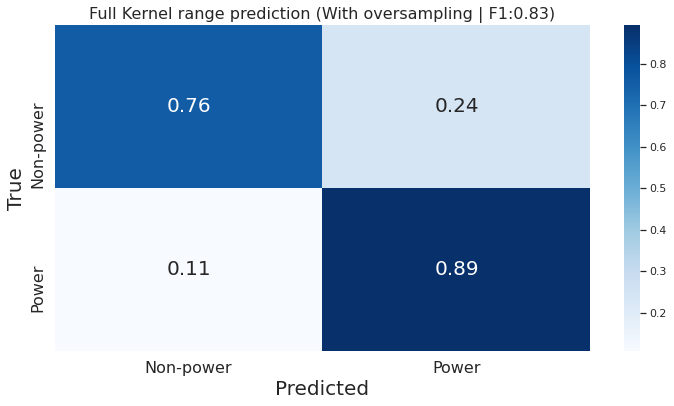

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(confusion_matrix(y_test_res, y_pred_res, normalize='true'), annot=True, cmap='Blues', annot_kws={'size':20})
plt.title(f"Full Kernel range prediction (With oversampling | F1:{f1_score(y_test_res, y_pred_res):.2})", fontsize=16)

ax.set_xticklabels(['Non-power', 'Power'], fontsize=16)
ax.set_yticklabels(['Non-power', 'Power'], fontsize=16)

ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("True", fontsize=20)

plt.show()

### Without oversampling on training data

In [25]:
model1 = RandomForestClassifier(n_estimators=40, max_features=0.5, n_jobs=-1, verbose=1)
model1.fit(x_train, y_train.values.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [26]:
model1.score(x_test ,y_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    0.1s finished


0.7256666666666667

In [27]:
y_pred = model1.predict(x_test)
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['Pred'])
y_pred_df.head()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    0.1s finished


,Pred
84,0
14628,1
2031,0
9846,0
9532,0


In [28]:
f1_nooversampling = f1_score(y_test, y_pred, average='weighted')
print(f1_nooversampling)

0.7096323126475743


In [29]:
report1 = classification_report(y_test, y_pred_df)
print(report1)

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      2000
           1       0.63      0.43      0.51      1000

    accuracy                           0.73      3000
   macro avg       0.69      0.65      0.66      3000
weighted avg       0.71      0.73      0.71      3000



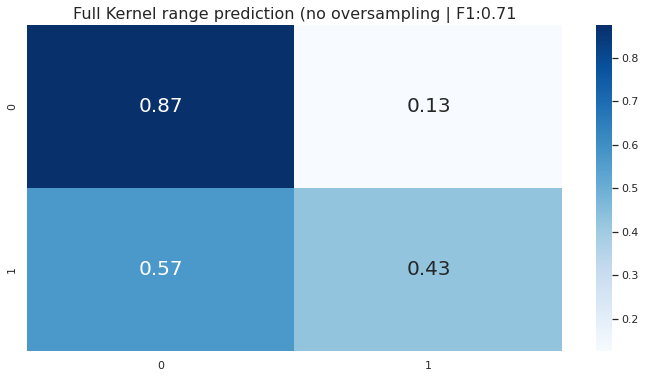

In [30]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(confusion_matrix(y_test, y_pred_df, normalize='true'), annot=True, cmap='Blues', annot_kws={'size':20})
plt.title(f"Full Kernel range prediction (no oversampling | F1:{f1_nooversampling:.2}", fontsize=16)
plt.show()

#### Some tests

In [ ]:
results = pd.concat([y_test, y_pred_df], axis=1)
results.head()

,label,Pred
84,0,0
14628,0,0
2031,0,0
9846,1,0
9532,1,0


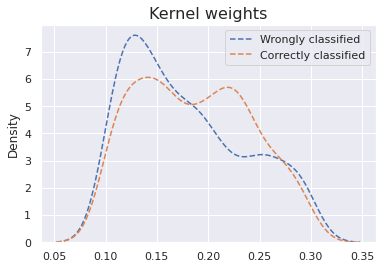

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(x_kerintegrals_df.take(results[(results['label'] == 1) & (results['Pred'] == 0)].index).values.ravel(), ls='--', label='Wrongly classified', ax=ax)
sns.kdeplot(x_kerintegrals_df.take(results[(results['label'] == 1) & (results['Pred'] == 1)].index).values.ravel(), ls='--', label='Correctly classified', ax=ax)
ax.set_title("Kernel weights", fontsize=16)
ax.legend()
plt.show()

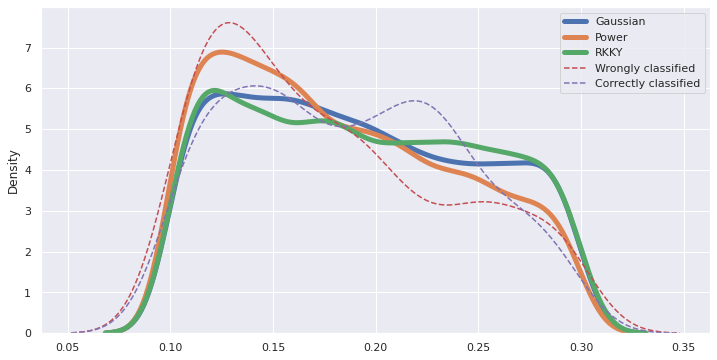

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.kdeplot(ker_integrals_gaus.values.ravel(), lw=5, label='Gaussian', alpha=0.4)
sns.kdeplot(ker_integrals_pow.values.ravel(), lw=5, label='Power', alpha=0.4)
sns.kdeplot(ker_integrals_rkky.values.ravel(), lw=5, label='RKKY', alpha=0.4)


sns.kdeplot(x_kerintegrals_df.take(results[(results['label'] == 1) & (results['Pred'] == 0)].index).values.ravel(), ls='--', label='Wrongly classified', ax=ax)
sns.kdeplot(x_kerintegrals_df.take(results[(results['label'] == 1) & (results['Pred'] == 1)].index).values.ravel(), ls='--', label='Correctly classified', ax=ax)

ax.legend()
plt.show()

### With oversampling on training data

In [31]:
from imblearn.over_sampling import RandomOverSampler
ovs = RandomOverSampler(random_state=101)
x_res, y_res = ovs.fit_sample(x_train, y_train.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [32]:
from collections import Counter
print("Training set before:",Counter(y_train.values.ravel()))
print("Training set after:",Counter(y_res))

Training set before: Counter({0: 8000, 1: 4000})
Training set after: Counter({1: 8000, 0: 8000})


In [33]:
model2 = RandomForestClassifier(n_estimators=100, max_features=0.5, n_jobs=-1, verbose=1)
model2.fit(x_res, y_res)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [34]:
model2.score(x_test, y_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.7353333333333333

In [35]:
f1_oversampling = f1_score(y_test, model2.predict(x_test), average='weighted')
print(f1_oversampling)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.7325734808561108


In [36]:
report2 = classification_report(y_test, model2.predict(x_test))
print(report2)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.79      0.82      0.81      2000
           1       0.61      0.56      0.59      1000

    accuracy                           0.74      3000
   macro avg       0.70      0.69      0.70      3000
weighted avg       0.73      0.74      0.73      3000



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


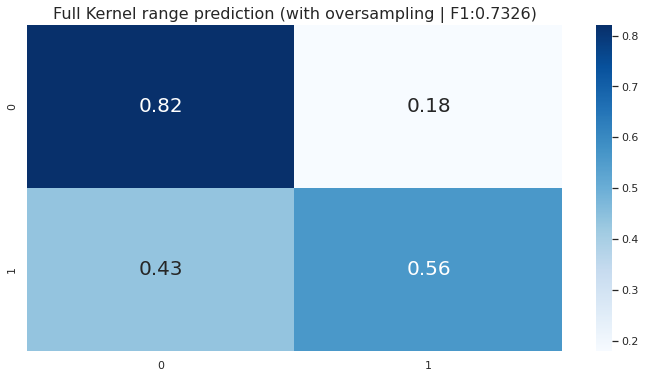

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(confusion_matrix(y_test, model2.predict(x_test), normalize='true'), annot=True, cmap='Blues', annot_kws={'size':20})
plt.title(f"Full Kernel range prediction (with oversampling | F1:{f1_oversampling:.4})", fontsize=16)
plt.show()

# Classification based on kernel integral values

In [38]:
pd.DataFrame(x_kerintegrals_res).describe().T

,count,mean,std,min,25%,50%,75%,max
0,20000.0,0.187744,0.057197,0.100009,0.137847,0.181706,0.234726,0.299927


In [39]:

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

def get_data_from_kerintegrals(lower_lim:float, upper_lim:float, ker_integrals, X:pd.DataFrame, y:pd.DataFrame):
    index = ker_integrals[(ker_integrals[0] >= lower_lim) & (ker_integrals[0] <= upper_lim)].index
    return X.take(index), y.take(index)

def classify_kerweights(x_df:pd.DataFrame ,y_df:pd.DataFrame ,
                        values:np.ndarray, ker_integrals:pd.DataFrame):

    ## Implement OVERsampling
    from imblearn.over_sampling import RandomOverSampler
    ovs = RandomOverSampler(random_state=42)
    #values = np.linspace(0.1, 0.3, 6)
    limits=[]
    scores = []
    cmat = []
    for id in range(len(values)-1):
        print(f"Running iter{id+1} ...")
        limits.append((values[id], values[id+1]))
        print(f"Using kernel limit values: {values[id]:.2} - {values[id+1]:.2}")
        x,y = get_data_from_kerintegrals(values[id], values[id+1],ker_integrals,  x_df, y_df)
        # x_resampled ,y_resampled = ovs.fit_sample(x, y)
        # X_train, X_test, y_train, y_test = train_test_split(x_resampled , y_resampled, test_size=0.2, stratify=y, random_state=101)
        X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, stratify=y, random_state=101)
        x_resampled ,y_resampled = ovs.fit_sample(X_train, y_train)
        """Print statistiscs"""
        print("Train set stats:", Counter(y_train.values.ravel()))
        print("Rebalanced Train set stats:", Counter(y_resampled))
        print("Test set stats:", Counter(y_test.values.ravel()))
        
        m = RandomForestClassifier(n_estimators=100, max_features="log2", n_jobs=-1, oob_score=True)
        print(f"\nFitting RF model ...")
        m.fit(x_resampled, y_resampled)
        scores.append((m.oob_score_, m.score(X_test, y_test),f1_score(m.predict(X_test), y_test,average='weighted')))
        print("Done scoring... Computing confusion matrix...")
        cmat.append(confusion_matrix(y_test, m.predict(X_test), normalize="true"))
        print()
    return limits, scores, cmat

In [40]:
# m = RandomForestClassifier(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1)
# scores = cross_val_score(m, x_train_res, y_train_res, scoring='f1_weighted',  cv=5, n_jobs=-1, verbose=2 )
# scores

In [43]:
lts, scores ,cmat = classify_kerweights(pd.DataFrame(x_res) ,
                                        pd.DataFrame(y_res),
                                        np.linspace(0.1,0.3,6),
                                        pd.DataFrame(x_kerintegrals_res))

Running iter1 ...
Using kernel limit values: 0.1 - 0.14
Train set stats: Counter({1: 2283, 0: 1934})
Rebalanced Train set stats: Counter({1: 2283, 0: 2283})
Test set stats: Counter({1: 571, 0: 484})

Fitting RF model ...
Done scoring... Computing confusion matrix...

Running iter2 ...
Using kernel limit values: 0.14 - 0.18
Train set stats: Counter({1: 1893, 0: 1749})
Rebalanced Train set stats: Counter({0: 1893, 1: 1893})
Test set stats: Counter({1: 474, 0: 437})

Fitting RF model ...
Done scoring... Computing confusion matrix...

Running iter3 ...
Using kernel limit values: 0.18 - 0.22
Train set stats: Counter({1: 1574, 0: 1566})
Rebalanced Train set stats: Counter({1: 1574, 0: 1574})
Test set stats: Counter({1: 394, 0: 392})

Fitting RF model ...
Done scoring... Computing confusion matrix...

Running iter4 ...
Using kernel limit values: 0.22 - 0.26
Train set stats: Counter({0: 1397, 1: 1241})
Rebalanced Train set stats: Counter({0: 1397, 1: 1397})
Test set stats: Counter({0: 349, 1: 

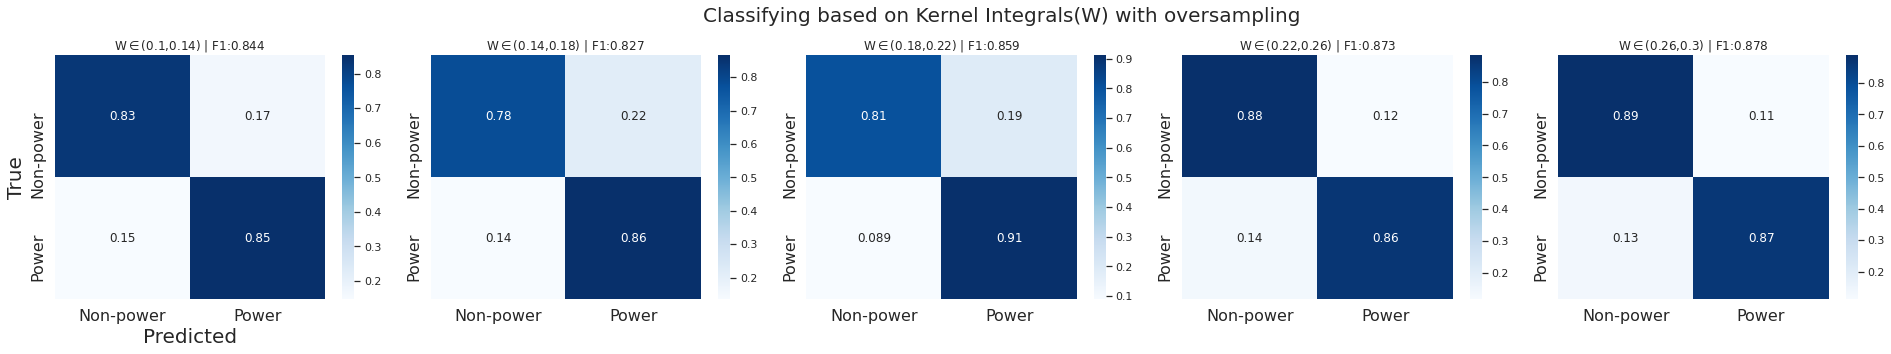

In [44]:
fig, axes = plt.subplots(1,5, figsize=(28,5))

for id in range(len(axes)):
    sns.heatmap(cmat[id], annot=True, cmap="Blues",ax=axes[id])
    axes[id].set_title(r"W$\in$"+f"({lts[id][0]:.2},{lts[id][1]:.2})"+f" | F1:{scores[id][2]:.3}")
    axes[id].set(xticks=[0.5,1.5], yticks=[0.5,1.5] )
    axes[id].set_xticklabels(['Non-power', 'Power'], fontsize=16)
    axes[id].set_yticklabels(['Non-power', 'Power'], fontsize=16)

axes[0].set_xlabel("Predicted", fontsize=20)
axes[0].set_ylabel("True", fontsize=20)

plt.suptitle("Classifying based on Kernel Integrals(W) with oversampling", fontsize=20)
plt.tight_layout(rect=[0,0, 0.95,0.93])
plt.show()

### Form a CV set of equal (power vs non-power) for high-kernel weight data and try classification

In [50]:
def train_cv_split(x_df:pd.DataFrame, y_df:pd.DataFrame, cv_size:float, random_state=101):
    """Splits the unbalanced training set with two y_labels into an unbalanced training set and a balanced cross-validation set
    Ideal to use cv_size = 0.1 
    Returns (x_train, y_train), (x_valid, y_valid)
    """
    # Use 10% of x_train as CV
    np.random.seed(random_state)
    nval_samples = int(len(x_df)*cv_size)
    type0_samples = np.random.choice(y_df[y_df.label == 0].index, nval_samples//2, replace=False)
    type1_samples = np.random.choice(y_df[y_df.label == 1].index, nval_samples//2, replace=False)
    val_set = np.concatenate([type0_samples, type1_samples])
    new_trainset_elems = [elem for elem in x_df.index if elem not in val_set]

    return (x_df.loc[new_trainset_elems], y_df.loc[new_trainset_elems]),(x_df.loc[val_set], y_df.loc[val_set])

In [46]:
new_x, new_y = get_data_from_kerintegrals(0.26, 0.3, x_kerintegrals_df, x_df, y_df)

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(new_x, new_y, test_size=0.2, stratify=new_y, random_state=101)
len(X_train)

1856

In [51]:
(x_train, y_train), (x_valid, y_valid) = train_cv_split(X_train, Y_train, cv_size=0.1, random_state=101)
len(x_train)

1672

In [52]:
print("Test set stats")
print(y_train.value_counts()/len(y_train))
print("\nTest set stats")
print(y_valid.value_counts()/len(y_valid))

Test set stats
label
0        0.754187
1        0.245813
dtype: float64

Test set stats
label
1        0.5
0        0.5
dtype: float64


In [53]:
print((y_train.value_counts()/len(y_train)))

label
0        0.754187
1        0.245813
dtype: float64


In [54]:
dict(y_train.value_counts()/len(y_train))

{(0,): 0.7541866028708134, (1,): 0.2458133971291866}

In [55]:
m = RandomForestClassifier(n_estimators=40, verbose=1, max_features='sqrt', n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=1,
                       warm_start=False)

In [56]:
m.score(x_valid, y_valid)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    0.0s finished


0.6032608695652174

In [57]:
f1_score(m.predict(x_valid), y_valid, average='weighted')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    0.0s finished


0.655947911044645